In [2]:
#import os
#if 'maawg' not in os.getcwd():
#    os.chdir("../maawg/m3_sf_2020_training")

In [125]:
import sys
IN_COLAB = 'google.colab' in sys.modules

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/evan-burke/m3_sf_2020_training/blob/master/how_ml_works.ipynb)  

In [126]:
from dataclasses import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
from IPython.display import Image, display

if IN_COLAB:
    from IPython.display import HTML
    from base64 import b64encode
    
else:
    from IPython.display import Video

In [4]:
import matplotlib.style as style
style.use('fivethirtyeight')
FIGSIZE = (13,8)

In [5]:
# Generate some random points
np.random.seed(23580918)
x = np.random.rand(100, 1) * 10
noise = (np.random.randn(100, 1) + 0.7) * 0.5
y = 0.8 + 0.3 * x + noise

In [6]:
def gen_random_line():   
    y_intercept_range = (0.3, 3)
    slope_range = (-0.1, 0.6)
    
    y_intercept = random.uniform(*y_intercept_range)
    slope = random.uniform(*slope_range)
    
    if slope <= -0.05 and y_intercept <0.1:
        # regenerate
        y_intercept, slope = gen_random_line()
            
    return y_intercept, slope


def compare_approx(x, y, threshold):
    if abs(x - y) < threshold:
        return True
    else:
        return False
    
def gen(chosen_vars):
    if chosen_vars is None:
        return gen_random_line()
    else:
        testvals = gen_random_line()
        for i in chosen_vars:
            if compare_approx(i.y_intercept, testvals[0], 0.3):
                if compare_approx(i.slope, testvals[1], 0.6):
                    # regenerate
                    return gen(chosen_vars)
        return testvals

In [7]:
@dataclass
class Line:
    color: str
    y_intercept: float
    slope: float
    cost: float = None

In [8]:
colors = ['b','g','r','c','m','y','k']
colormap = {'b':'blue',
            'g':'green',
            'r':'red',
            'c':'cyan',
            'm':'magenta',
            'y':'yellow',
            'k':'black'
           }
inverse_colormap = {}
for i in colormap:
    inverse_colormap[colormap[i]] = i

In [9]:
def plot_points(red=False, random_lines=None, lines=None, savefile=None):
    
    _colors = random.sample(colors, len(colors))
    
    #compare_threshold = 0
    
    plt.figure(figsize=FIGSIZE)
    plt.scatter(x,y,s=55)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis((-0.03, 10.1, -0.03, 6)) #xmin, xmax, ymin, ymax
    
    if lines is not None:
        for i in lines:
            if i.color in inverse_colormap:
                color = inverse_colormap[i.color]
            else:
                color = i.color
            plt.plot(x, i.y_intercept + i.slope * x, color)

    chosen_vars = []
    if random_lines is not None:
        if random_lines > 7:
            random_lines = 7
            
        for i in range(random_lines):
            rl = gen(chosen_vars)
            randcolor = colors[i]
            chosen_vars.append(Line(colormap[randcolor], rl[0], rl[1]))
            plt.plot(x, rl[0] + rl[1] * x, randcolor)
    
    if red:
        plt.plot(x, 1.2 + 0.3 * x, "r")

    if savefile:
        plt.savefig(savefile)
        plt.close()
    else:
        plt.show()
    if chosen_vars:
        return chosen_vars

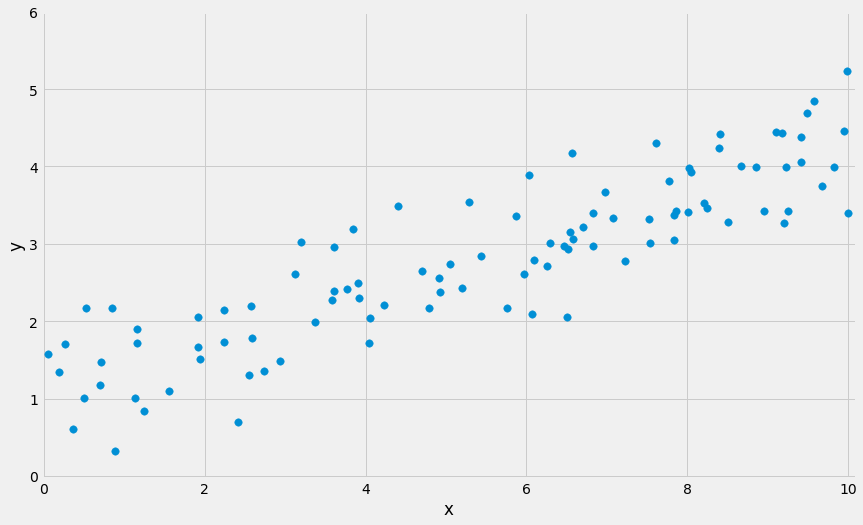

In [12]:
plot_points(0)

But software can't "see" the general shape in the same way we can. To them, it's more like this:

In [13]:
for i in range(50):
    print(x[i][0], y[i][0], sep="  \t")

9.824886792952027  	3.9892042920127397
7.614293563673678  	4.302287378934495
6.978674980129168  	3.6734544467487713
1.936041598735947  	1.5136530530756027
4.914338089223151  	2.552892131775596
9.989118582079097  	5.23969268387858
8.6679166394225  	4.007610919693362
6.099541474491854  	2.7973492968744202
6.833857182160652  	2.9666885433456596
3.6114497059205295  	2.3898412352428022
6.565332786261937  	4.178661461023332
9.422695762706736  	4.060874255654454
4.9208568809557995  	2.3775302833850733
9.201495353176144  	3.2743960971861537
6.5427038362258605  	3.1544958709079225
6.708138638571142  	3.220400281957546
7.543219731173149  	3.0049766128657773
8.053341337475771  	3.923364411638097
8.0107316584253  	3.4085177439656533
8.856036117658483  	3.9968195196556717
9.573759826009857  	4.844513513714544
9.949238135741451  	4.457982160271245
5.869402897262168  	3.3563134023279195
8.245636960680413  	3.4581734962694908
9.674058181171876  	3.7444270290941746
8.206366299502733  	3.523505819638344

Now, we could start generating lines at random and seeing how well they fit the data.

Which one looks best? Worst?

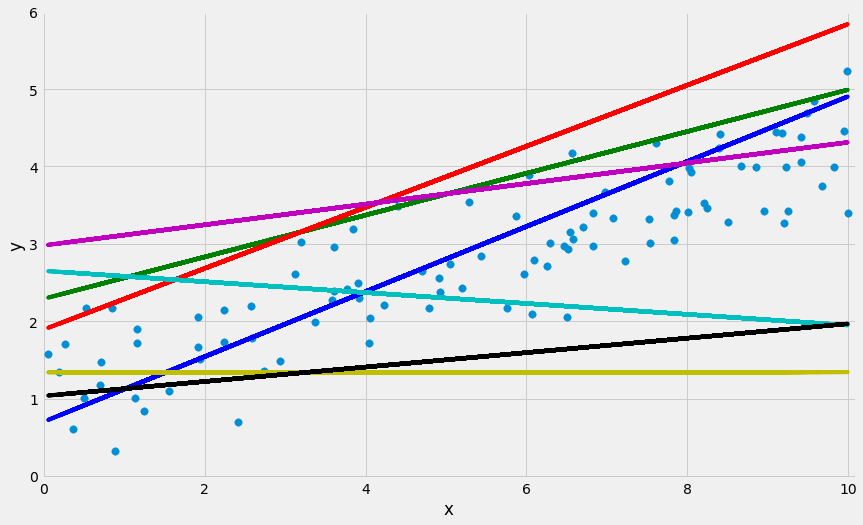

In [14]:
random_lines = plot_points(0, 8)

If we want to figure out which one is closest, we need to have a way to score each of these lines.

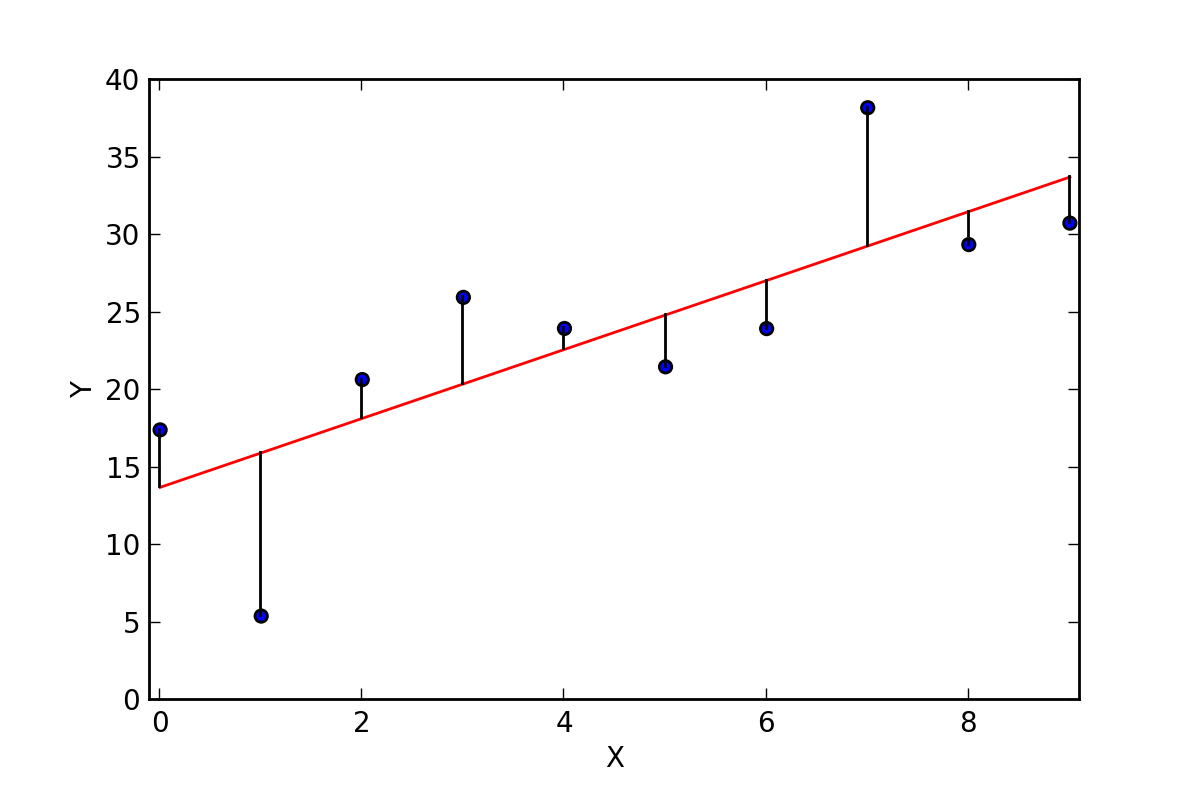

In [15]:
display(Image("img/fit_errors.png")) #, width=800))

In [16]:
def line_equation(yi, slope, x):
    return yi + slope * x

def score(line):
    y_predict = []
    for i in x:
        y_predict.append(line_equation(line.y_intercept, line.slope, i))
    residuals = y_predict - y

    cost = np.sum((residuals ** 2)) / (2 * x.shape[0])
    return cost

def score_lines(lines):
    for n, i in enumerate(lines):
        cost = score(i)
        lines[n].cost = cost
    scores = sorted(lines, key=lambda i: i.cost)
    
    return scores, pd.DataFrame([asdict(i) for i in scores])

In [55]:
line_scores, df = score_lines(random_lines)
df.index = df['color']

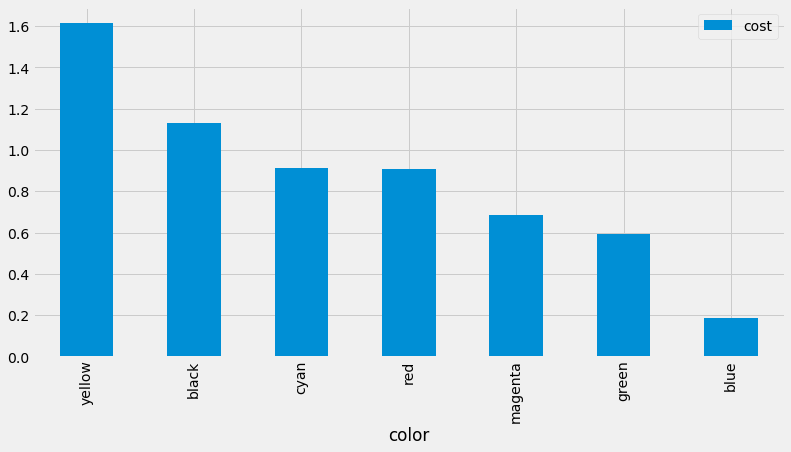

In [56]:
df[['color','cost']].sort_values('cost', ascending=False).plot(kind="bar", figsize=(12,6))

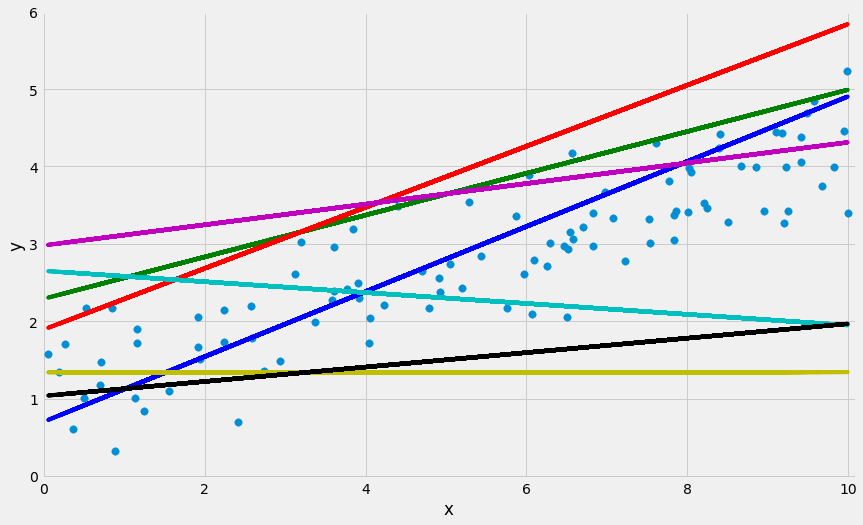

In [18]:
plot_points(lines=random_lines)

A brief digression...

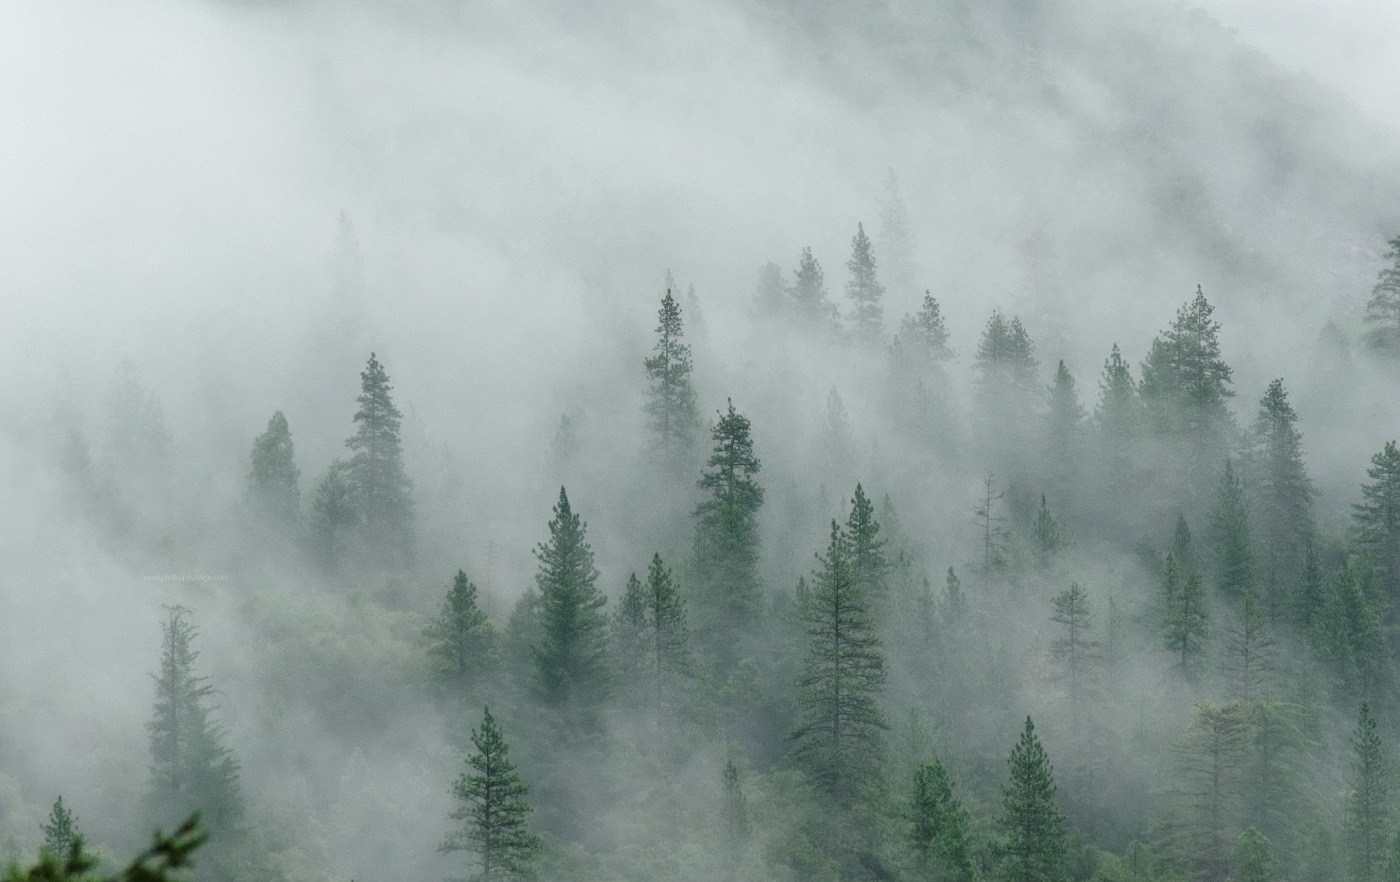

In [19]:
display(Image("img/fog.jpg"))

FANCY COMPUTER MATH GOES HERE

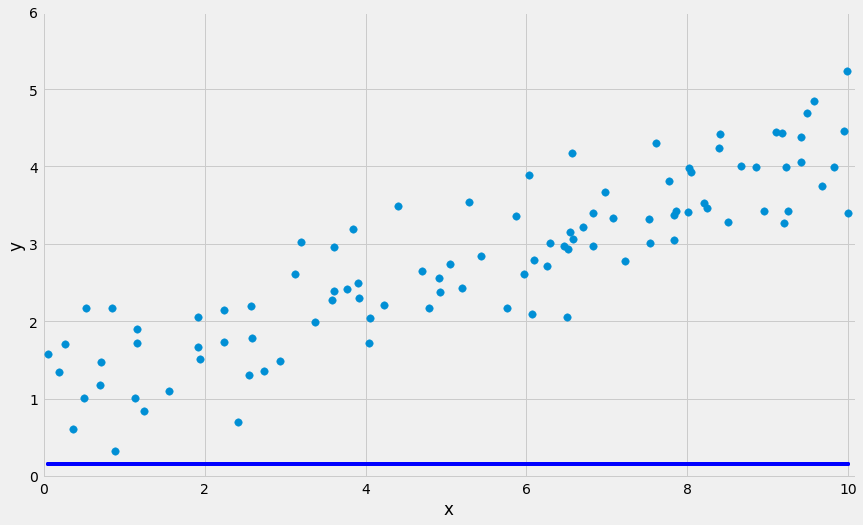

In [89]:
boring_line = Line('blue', 0.15, 0)
plot_points(lines=[boring_line])

In [90]:
def show_cost(Line):
    if not Line.cost:
        Line.cost = score(Line)
    print("cost:", round(Line.cost,2), "\n")

In [91]:
def gradient_descent(starting_line, learning_rate, epochs, 
                     new_color='cyan', 
                     sleep=None, 
                     verbose=False):
    
    yi = starting_line.y_intercept
    s = starting_line.slope
    n = int(len(x))
    all_lines = []
    
    if not starting_line.cost:
        starting_line.cost = score(starting_line)
    all_lines.append(starting_line)
    
    if verbose:
        echo_every_x_iters = int(epochs/10)
    
    for i in range(epochs): 
        y_pred = s*x + yi  # Output of this line's function for this x value
        D_s = (-2/n) * sum(x * (y - y_pred))
        D_yi = (-2/n) * sum(y - y_pred) 
        s = s - learning_rate * D_s  # Update slope
        yi = yi - learning_rate * D_yi  # Update y-intercept
        
        iter_line = Line(color=starting_line.color, y_intercept=yi, slope=s)
        iter_line.cost = score(iter_line)
        all_lines.append(iter_line)
        
        if verbose:
            if (i+1) % echo_every_x_iters == 0:

                print("after", i+1, "epochs:", round(iter_line.cost,3))
                if sleep:
                    time.sleep(sleep)
    
    final_line = Line(color=new_color, y_intercept=yi, slope=s)

    return final_line, all_lines

MACHINES, I HEREBY ORDER YOU TO LEARN:

In [98]:
learning_rate = 0.0003  # Learning rate
epochs = 20  # The number of iterations of gradient descent to do

print("\nStarting values for this line:")
show_cost(boring_line)

trained_20, training_trend_20 = gradient_descent(boring_line, 
                           learning_rate=learning_rate,
                           epochs=epochs, 
                           new_color='cyan',
                           sleep=0.35,
                           verbose=True)

print("\nFinal values for this line:")
show_cost(trained_20)


Starting values for this line:
cost: 4.05 

after 2 epochs: 3.71
after 4 epochs: 3.397
after 6 epochs: 3.113
after 8 epochs: 2.854
after 10 epochs: 2.617
after 12 epochs: 2.403
after 14 epochs: 2.207
after 16 epochs: 2.029
after 18 epochs: 1.866
after 20 epochs: 1.718

Final values for this line:
cost: 1.72 



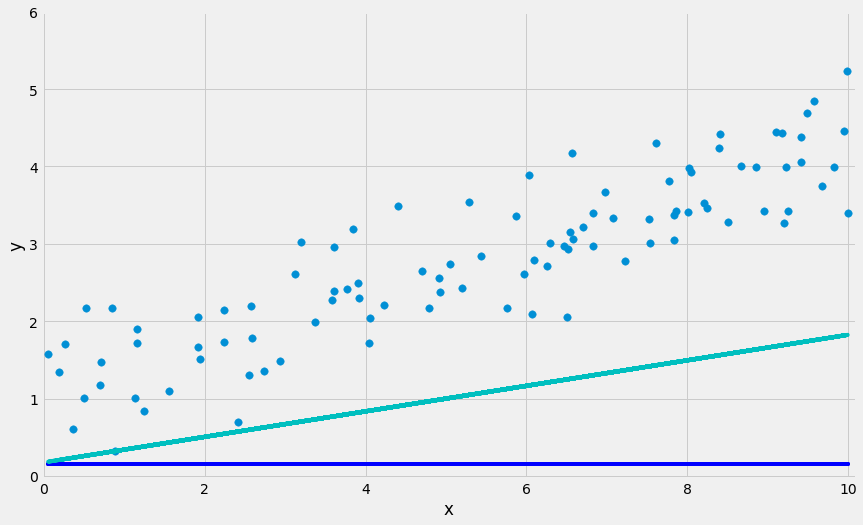

In [100]:
plot_points(lines=[boring_line, trained_20])

TIME FOR MORE LEARNING

In [117]:
learning_rate = 0.0005

epochs = 100
trained_100, training_trend_100 = gradient_descent(boring_line,
                               learning_rate=learning_rate,
                               epochs=epochs,
                               new_color='green',
                               verbose=True)

after 10 epochs: 1.962
after 20 epochs: 1.009
after 30 epochs: 0.575
after 40 epochs: 0.377
after 50 epochs: 0.287
after 60 epochs: 0.246
after 70 epochs: 0.227
after 80 epochs: 0.218
after 90 epochs: 0.214
after 100 epochs: 0.211


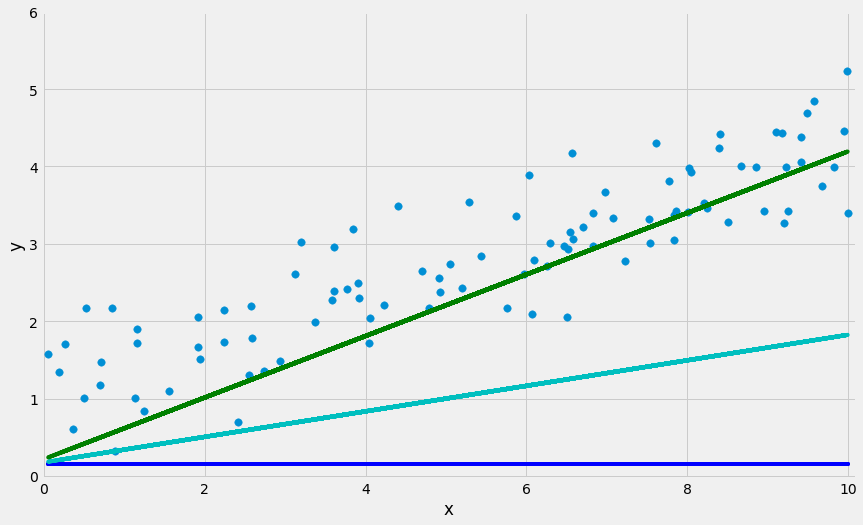

In [102]:
plot_points(lines=[boring_line, trained_20, trained_100])

We can even look at how the cost changes during training:

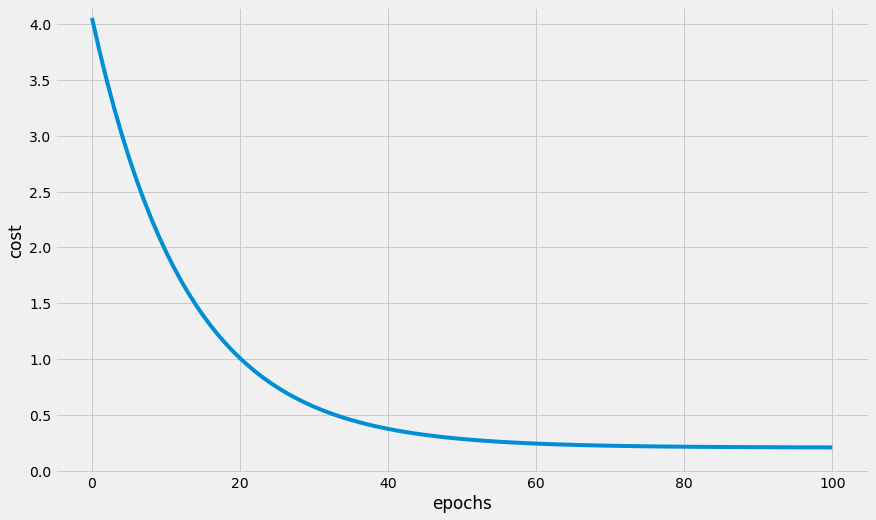

In [119]:
def plot_trend(training_trend):
    cost_values = [i.cost for i in training_trend]
    plt.figure(figsize=FIGSIZE)
    plt.xlabel('epochs')
    plt.ylabel('cost')
    plt.plot(cost_values)
    plt.axis((None, None, -0.02, max(cost_values) + 0.1)) #xmin, xmax, ymin, ymax
    plt.show()
    
plot_trend(training_trend_100[0:])

We can watch how the line moves to fit better over the course of training too:

In [124]:
# Import pre-rendered video
video_path = "img/train100.mp4"

if IN_COLAB:
    mp4 = open(video_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

else:
    Video(video_path)

WHAT IF WE WENT TOTALLY CRAZY WITH LEARNING, JUST SO MUCH LEARNING THERE SHOULD BE A LAW AGAINST IT?

In [104]:
epochs = 1000
trained_1000, training_trend_1000 = gradient_descent(boring_line,
                               learning_rate=learning_rate,
                               epochs=epochs,
                               new_color='orange')

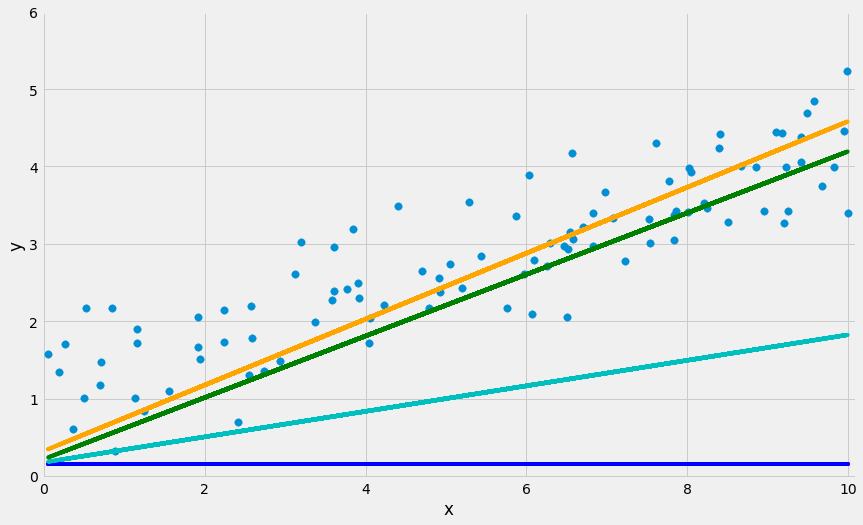

In [105]:
plot_points(lines=[boring_line, trained_20, trained_100, trained_1000])

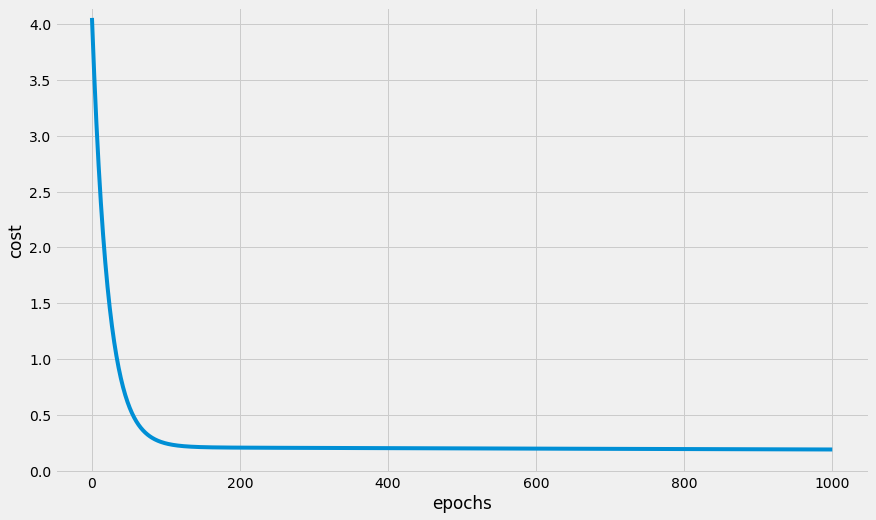

In [106]:
plot_trend(training_trend_1000[0:])

In [122]:
# appendix


# Export to png for animation.
# Watch out, generates lots of files.
def export_pngs(trend, sample_every=None):
    
    def export(line, incr):
        savefile = "train_{:05}.png".format(incr)
        plot_points(lines=[i], savefile=savefile)
        
    
    itercount = 0
    for i in trend:
        # ffmpeg requires no gaps in image numbering sequence, so use 'itercount' if sampling
        if sample_every:
            # export only once every N epochs
            export(i, itercount)
            itercount += 1
            print(itercount, end=", ")
            
        else:
            # export all epochs
            export(i, itercount)
            itercount += 1
            if n % 5 == 0:
                print(itercount, end=", ")

    print()

#export_pngs(training_trend_100) #, sample_every=7)

## Then stitch to video with ffmpeg on the command line:
## ffmpeg -framerate 20 -i train_%05d.png train100.mp4

